# from allcools page: https://lhqing.github.io/ALLCools/cell_level/step_by_step/100kb/05-DecompositionAndEmbedding.html
Purpose
The purpose of this step is to run PCA and manifold leanring (tSNE and UMAP) on the cell-by-feature matrix, feature to use can be either HVF or CEF. We use both the mCH and mCG matrix. We first run PCA on mCH and mCG matrix separately, and then concatenate mCH and mCG top PCs together to run KNN, followed by tSNE and UMAP embedding.



In [ ]:
Input
HVF adata files.

Output
HVF adata file with PCA, tSNE and UMAP calculated.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import anndata

from ALLCools.clustering import tsne, balanced_pca, significant_pc_test, log_scale
from ALLCools.plot import *

In [2]:
sns.set_context(context='notebook', font_scale=1.3)

In [47]:
# cell metadata path
metadata_path = 'CellMetadata.PassQC_oocyte.csv'
mcds_paths = 'mcds/chrom100k'
var_dim = 'chrom100k'
# HVF mC Fraction AnnData Files
ch_adata_path = 'mCH.HVF.h5ad'
cg_adata_path = 'mCG.HVF.h5ad'

# use feature type
# HVF: all highly variable features
# CEF: cluster enriched features
feature_type = 'HVF' 
pre_cluster_name = 'leiden'

# n_components
n_components = 'auto'  # if auto, will use Kolmogorov-Smirnov test to test the adjacent PCs and cut when P > p_cutoff
p_cutoff = 0.1  # ks test p value cutoff, only apply when n_components == 'auto'

# downsample large clusters
max_cell_prop = 0.05

In [4]:
metadata = pd.read_csv(metadata_path, index_col=0)
metadata

,Date,Type of sample,WellID,WellBarcode,AnimalID,Type,TotalRead,mCGFrac,Group,SampleName
SampleID,,,,,,,,,,
3889744700PO1NC5D1S,44700,Pooled Oocytes (5) #1,D1,CAGTCACA,38897,PO,10700000,0.693,Stressed,3889744700PO1NC5D1S_1_val_1_bismark_bt2_pe.all...
3905345005PO1NC2I1S,45005,Pooled Oocytes (2) #1,I1,TGATAGGC,39053,PO,2700000,0.623,Stressed,3905345005PO1NC2I1S_1_val_1_bismark_bt2_pe.all...
4129944963PO1NC3N1S,44963,Pooled Oocytes (3) #1,N1,ATTCCGCT,41299,PO,2900000,0.626,Stressed,4129944963PO1NC3N1S_1_val_1_bismark_bt2_pe.all...
4129944963PO2NC4M1S,44963,Pooled Oocytes (4) #2,M1,CACGCAAT,41299,PO,2300000,0.684,Stressed,4129944963PO2NC4M1S_1_val_1_bismark_bt2_pe.all...
4129944963PO3NC3O1S,44963,Pooled Oocytes (3) #3,O1,AGAAGGAC,41299,PO,4800000,0.641,Stressed,4129944963PO3NC3O1S_1_val_1_bismark_bt2_pe.all...
...,...,...,...,...,...,...,...,...,...,...
4636344664SO3NC1K9C,44664,Single Oocyte #3,K9,TCAGACAC,46363,SO,4900000,0.689,Control,4636344664SO3NC1K9C_1_val_1_bismark_bt2_pe.all...
4660644938SO1NC1M9C,44938,Single Oocyte #1,M9,ATGCGTCA,46606,SO,43500000,0.691,Control,4660644938SO1NC1M9C_1_val_1_bismark_bt2_pe.all...
4660644938SO2NC1N9C,44938,Single Oocyte #2,N9,CACAGGAA,46606,SO,4800000,0.685,Control,4660644938SO2NC1N9C_1_val_1_bismark_bt2_pe.all...


In [5]:
ch_adata = anndata.read_h5ad(ch_adata_path)
cg_adata = anndata.read_h5ad(cg_adata_path)

In [13]:
ch_adata.obs

,leiden
cell,
4636344664PO1NC5L9C,2
4598245001PO2NC4F8C,1
4566944700PO2NC5P8C,5
4520844650PO1NC5A7S,3
4139144650PO3NC3E3C,2
...,...
4566944964SO1NC1O7C,4
4598245001SO1NC1B9C,3
4636344664SO3NC1K9C,0


In [6]:
if feature_type == 'CEF':
    print('Using Cluster Enriched Features')
    ch_adata = ch_adata[:, ch_adata.var[f'{pre_cluster_name}_enriched_features']].copy()
    cg_adata = cg_adata[:, cg_adata.var[f'{pre_cluster_name}_enriched_features']].copy()

Using Cluster Enriched Features


In [7]:
ch_scaler = log_scale(ch_adata)

cg_scaler = log_scale(cg_adata)

adata.X is already log transformed, skip log step.
adata.X is already log transformed, skip log step.


/share/lasallelab/Ensi/anaconda3/lib/python3.11/site-packages/ALLCools/clustering/balanced_pca.py:173: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, sub_df in adata.obs.groupby(groups):


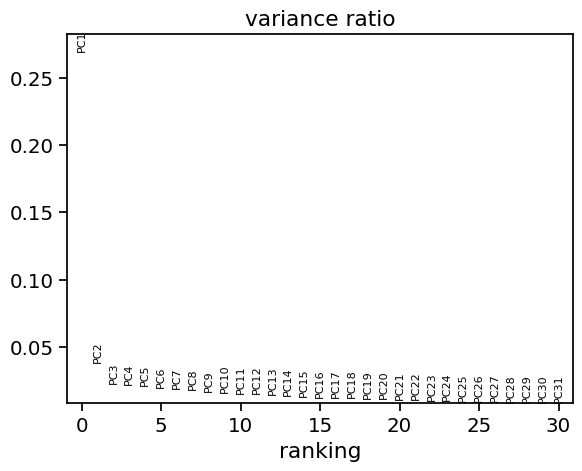

only 2 passed the P cutoff, in order to proceed following analysis, will use first 4 PCs
Changing adata.obsm['X_pca'] from shape (120, 100) to (120, 4)


In [8]:
#RUN PCA mCH
balanced_pca(ch_adata, groups=pre_cluster_name)
sc.pl.pca_variance_ratio(ch_adata)
ch_n_components = significant_pc_test(ch_adata, p_cutoff=p_cutoff)

In [9]:
#save
plt.savefig("05f_mCH_pcacomponents_chrm100k.png")


<Figure size 640x480 with 0 Axes>

In [15]:
#PCA-mCH

hue = 'mCHFrac'
if hue in metadata.columns:
    ch_adata.obs[hue] = metadata[hue].reindex(ch_adata.obs_names)
    fig, axes = plot_decomp_scatters(ch_adata,
                                     n_components=ch_n_components,
                                     hue=hue,
                                     hue_quantile=(0.25, 0.75),
                                     nrows=5,
                                     ncols=5)

In [ ]:
#save
plt.savefig("05f_PCAmCH_chrm100k.png")


/share/lasallelab/Ensi/anaconda3/lib/python3.11/site-packages/ALLCools/clustering/balanced_pca.py:173: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, sub_df in adata.obs.groupby(groups):


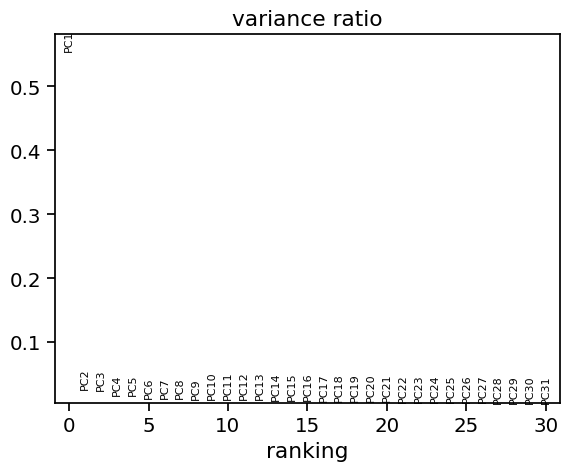

4 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (120, 100) to (120, 4)


In [16]:
# RUN PCA mCG

balanced_pca(cg_adata, groups=pre_cluster_name)
sc.pl.pca_variance_ratio(cg_adata)
cg_n_components = significant_pc_test(cg_adata, p_cutoff=p_cutoff)

In [17]:
#save
plt.savefig("05f_mCG_pcacomponents_chrm100k.png")

<Figure size 640x480 with 0 Axes>

Red axis labels are used PCs


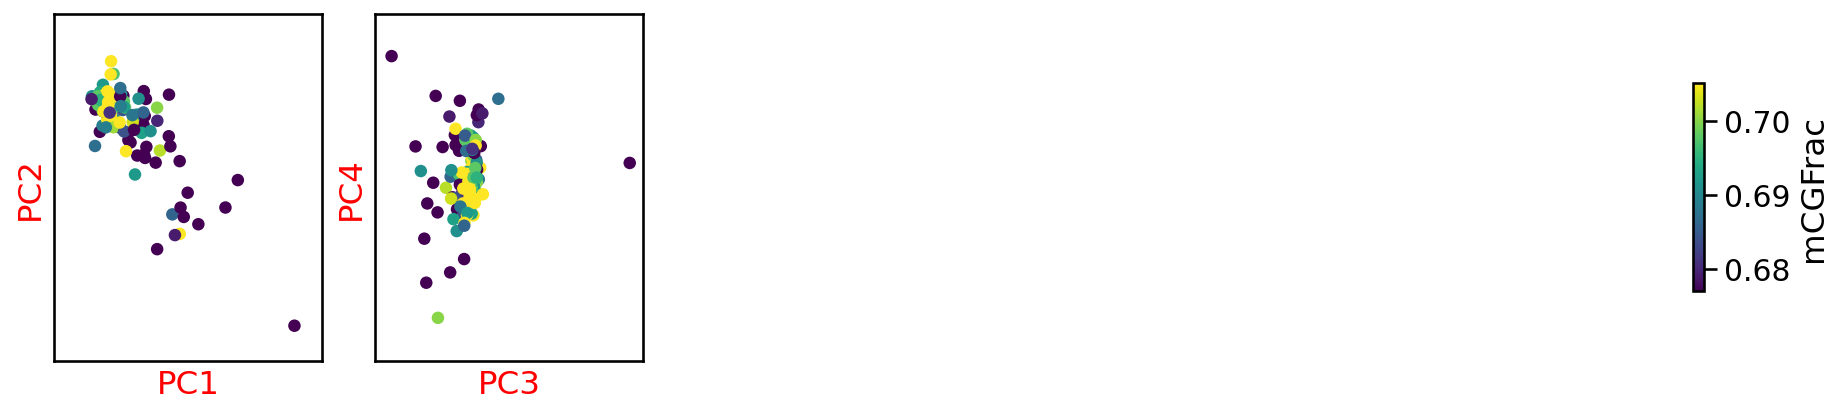

In [18]:
# PCA mCG


hue = 'mCGFrac'
if hue in metadata.columns:
    cg_adata.obs[hue] = metadata[hue].reindex(cg_adata.obs_names)
    fig, axes = plot_decomp_scatters(cg_adata,
                                     n_components=cg_n_components,
                                     hue=hue,
                                     hue_quantile=(0.25, 0.75),
                                     nrows=5,
                                     ncols=5)

In [19]:
#save
plt.savefig("05f_PCAmCG_chrm100k.png")


<Figure size 640x480 with 0 Axes>

In [21]:
# combined PCs

ch_pcs = ch_adata.obsm['X_pca'][:, :ch_n_components]
cg_pcs = cg_adata.obsm['X_pca'][:, :cg_n_components]

# scale the PCs so CH and CG PCs has the same total var
cg_pcs = cg_pcs / cg_pcs.std()
ch_pcs = ch_pcs / ch_pcs.std()

# total_pcs
total_pcs = np.hstack([ch_pcs, cg_pcs])
total_pcs

array([[-1.59567201e+00, -9.85775050e-03, -3.77607010e-02,
         3.25403772e-02, -1.36725581e+00,  1.26778603e-01,
         4.94463146e-02,  4.50802371e-02],
       [ 1.96164012e+00, -2.11621150e-01, -9.05519165e-03,
        -9.77552030e-03,  7.73001790e-01, -1.43343940e-01,
        -1.17004588e-01, -1.12206399e-01],
       [ 3.60427856e-01, -4.29290831e-02,  5.67470156e-02,
         1.87145062e-02, -6.70811296e-01,  6.82653114e-03,
        -5.67332953e-02, -8.01875889e-02],
       [-4.60318148e-01, -2.57293135e-01, -1.45099282e-01,
        -1.29237428e-01, -1.43108571e+00, -4.56072949e-02,
         1.34811386e-01,  2.12231815e-01],
       [-1.39347744e+00,  1.18863238e-02, -2.59321787e-05,
        -2.07907539e-02, -1.40736997e+00,  9.15705264e-02,
         9.22031403e-02, -5.87397367e-02],
       [-1.40057576e+00, -9.38999876e-02, -6.48130476e-02,
         3.41583677e-02, -1.01779604e+00,  1.03960358e-01,
         4.53248136e-02, -5.19767478e-02],
       [-1.12494476e-01, -5.820345

In [23]:
# make a copy of adata, add new pcs
# this is suboptimal, will change this when adata can combine layer and X in the future
adata = ch_adata.copy()

In [24]:
adata.obsm['X_pca'] = total_pcs
del adata.uns['pca']
del adata.varm['PCs']

In [25]:
# Manifold learing

tsne(adata,
     obsm='X_pca',
     metric='euclidean',
     exaggeration=-1,  # auto determined
     perplexity=30,
     n_jobs=-1)

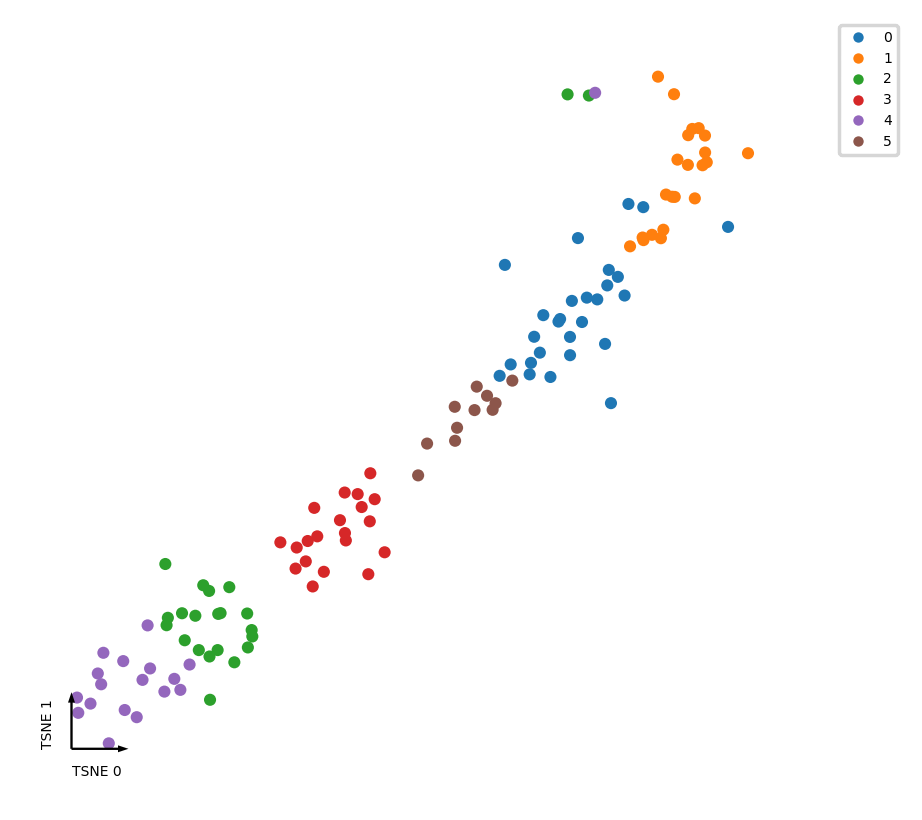

In [26]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = categorical_scatter(data=adata, ax=ax, coord_base='tsne', hue=pre_cluster_name, show_legend=True)


In [27]:
# Save the plot
fig.savefig("05f_tSNE_chrom100K_bothmC_plot.png")


In [28]:
# UMAP

sc.pp.neighbors(adata)
try:
    sc.tl.paga(adata, groups=pre_cluster_name)
    sc.pl.paga(adata, plot=False)
    sc.tl.umap(adata, init_pos='paga')
except:
    sc.tl.umap(adata)

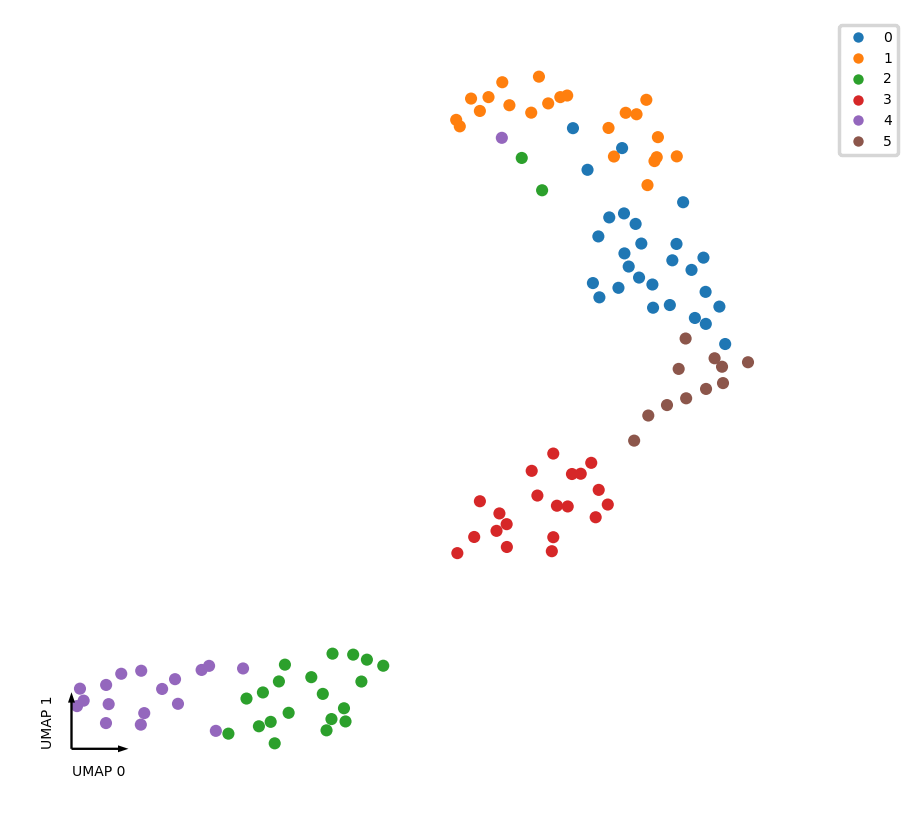

In [29]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = categorical_scatter(data=adata, ax=ax, coord_base='umap', hue=pre_cluster_name, show_legend=True)

In [30]:
# Save the plot
fig.savefig("05f_UMAP_chrom100K_bothmC_plot.png")


In [35]:
# Save the plot as an HTML file

### this chunck of code is to run the inetractive_scatter function and save it as html file
import plotly.express as px
import plotly.io as pio
from ALLCools.plot import interactive_scatter

/share/lasallelab/Ensi/anaconda3/lib/python3.11/site-packages/plotly/express/_core.py:1958: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



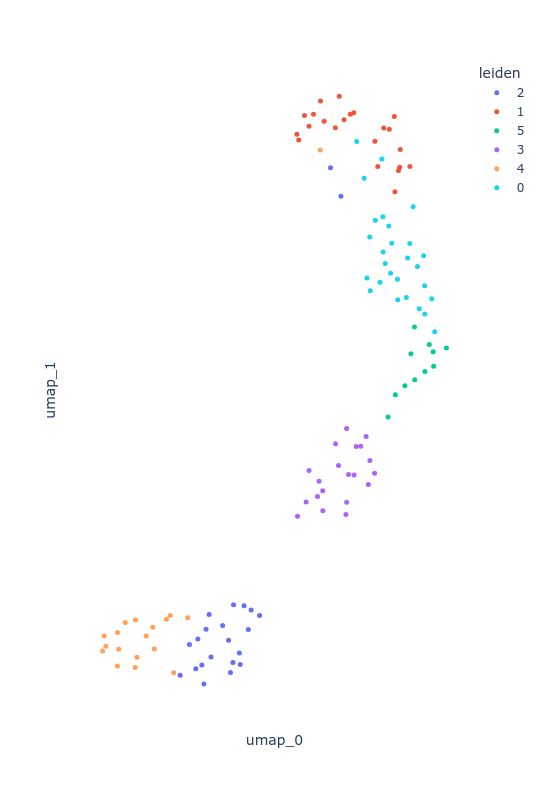

In [37]:
# interactive plot

# in order to reduce the page size, I downsample the data here, you don't need to do this
interactive_scatter(data=adata,
                    hue=pre_cluster_name,
                    coord_base='umap')

In [39]:
# Generate the interactive scatter plot
fig = interactive_scatter(data=adata, hue=pre_cluster_name, coord_base='umap')

html_file_path = "05f_interactive_umap_plot.html"
pio.write_html(fig, file=html_file_path, auto_open=True)

/share/lasallelab/Ensi/anaconda3/lib/python3.11/site-packages/plotly/express/_core.py:1958: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [40]:
adata.write_h5ad(f'adata.with_coords.h5ad')
adata

AnnData object with n_obs × n_vars = 120 × 1483
    obs: 'leiden'
    var: 'chrom', 'end', 'start', 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select', 'CGN_mean', 'CGN_dispersion', 'CGN_cov', 'CGN_score', 'CGN_feature_select', 'leiden_enriched_features'
    uns: 'leiden', 'leiden_colors', 'leiden_feature_enrichment', 'log', 'neighbors', 'umap', 'paga', 'leiden_sizes'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    obsp: 'connectivities', 'distances'

In [51]:
# save reproducable PCA

# ReproduciblePCA
# This class can save the selected features, scaler loadings and PC loadings into one object.
# The saved object can transform a new MCDS object from raw counts all the way to adata with PCs, allowing 
# quick preprocessing to prepare input for the downstream prediction, integration and clustering analysis.

from ALLCools.clustering import ReproduciblePCA

ch_rpca = ReproduciblePCA(scaler=ch_scaler, mc_type='CHN', adata=ch_adata)
ch_rpca.dump('CHN.ReproduciblePCA.lib')

cg_rpca = ReproduciblePCA(scaler=cg_scaler, mc_type='CGN', adata=cg_adata)
cg_rpca.dump('CGN.ReproduciblePCA.lib')


In [53]:
# how to use ReproduciblePCA to quickly transfer MCDS into adata with PCs¶

import joblib
from ALLCools.mcds import MCDS

mcds = MCDS.open(mcds_paths)
ch_rpca = joblib.load('CHN.ReproduciblePCA.lib')
adata = ch_rpca.mcds_to_adata_with_pc(mcds)
# adata will have the same var selected and PC space.


IndexError: boolean index did not match indexed array along dimension 0; dimension is 31764 but corresponding boolean dimension is 1483